In [153]:
#pip install xgboost
#!pip install dtreeviz
#!pip install optuna
#!pip install tensorflow
#!pip install keras-tuner

In [154]:
# Genearal usage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import scipy.stats as stats
import copy
import itertools
import math
import warnings

# Linear models
from sklearn import linear_model
from statsmodels.formula.api import ols

# model preparation and evaluation
from sklearn.metrics import mean_absolute_percentage_error

# XGBoost
import xgboost as xgb
from dtreeviz.trees import *
from sklearn import model_selection
import optuna

# LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import Hyperband

#Ensemble
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

<img src="raw/bikeProblem.png" width="600" height="500">

Load test and test data (See Bike_EDA_PreProcessing.ipynb for details)

In [155]:
X_train = pd.read_excel('raw/X_train.xlsx')
y_train = pd.read_excel('raw/y_train.xlsx')
X_train_c = pd.read_excel('raw/X_train_c.xlsx')
y_train_c = pd.read_excel('raw/y_train_c.xlsx')
X_train_r = pd.read_excel('raw/X_train_r.xlsx')
y_train_r = pd.read_excel('raw/y_train_r.xlsx')

X_test = pd.read_excel('raw/X_test.xlsx')
y_test = pd.read_excel('raw/y_test.xlsx')
X_test_c = pd.read_excel('raw/X_test_c.xlsx')
y_test_c = pd.read_excel('raw/y_test_c.xlsx')
X_test_r = pd.read_excel('raw/X_test_r.xlsx')
y_test_r = pd.read_excel('raw/y_test_r.xlsx')

<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task1</b> <h style="font-size: 18px;"> : Develop at least two different models and train them on the training set. Find a proper way to combine prediction results of these model. </h>
<hr style="border-top: 0.5px solid #b;">

##### 1) XGBoost

Training Steps:
['temp', 'hum', 'weathersit', 'workingday', 'season', 'yr', 'hr']
1. Predict 'casual' using ['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']
2. Predict 'register' using ['temp', 'hum', 'season', 'yr', 'hr']
3. Add 1. 2. together to derive the predicted 'cnt'
4. Predict 'cnt' using  ['temp', 'hum', 'hr', 'yr', 'season'] to ensemble with the other model and to assess the performance comparison to the model generated in 3..

1.1) Predict 'casual'

In [156]:
# reduce the feature to the selected ones.
X_train_c = X_train_c[['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']]
X_test_c = X_test_c[['temp', 'hum', 'weathersit', 'workingday', 'yr', 'hr']]

In [157]:
y_train_c.set_index('datetime', inplace = True)
y_test_c.set_index('datetime', inplace = True)

In [158]:
model_xgb_c = xgb.XGBRegressor()

def objective(trial):
    
    #hyperparameter searching
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    model_xgb_c.set_params(**params)
    #CV config
    score = model_selection.cross_val_score(model_xgb_c,
                                            X_train_c,
                                            y_train_c,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    val = - score.mean()
    return val

In [159]:
# Searching for the optimal hyperparameter
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(f"The best parameters are : \n {study.best_params}")

[I 2024-03-24 20:08:26,606] A new study created in memory with name: no-name-418bbfe3-4bbc-4b77-afe2-50e83edaeb65
C:\Users\Ryo\AppData\Local\Temp\ipykernel_22080\753032069.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-03-24 20:08:34,021] Trial 0 finished with value: 2293.4465722994146 and parameters: {'max_depth': 1, 'n_estimators': 765, 'learning_rate': 8.696408235686791e-08}. Best is trial 0 with value: 2293.4465722994146.
[I 2024-03-24 20:08:35,832] Trial 1 finished with value: 1076.218772260972 and parameters: {'max_depth': 1, 'n_estimators': 525, 'learning_rate': 0.18042245868535758}. Best is trial 1 with value: 1076.218772260972.
[I 2024-03-24 20:08:39,147] Trial 2 finished with value: 1009.2025573026552 and parameters: {'max_depth': 7, 'n_estimators': 464, 'learning_rate': 0.0013363838584906002}. Best is tria

The best parameters are : 
 {'max_depth': 6, 'n_estimators': 501, 'learning_rate': 0.008751999504675966}


In [160]:
model_xgb_c = xgb.XGBRegressor(**study.best_params)
model_xgb_c.fit(X_train_c.values, y_train_c.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008751999504675966,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=501, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [161]:
importance = pd.DataFrame(zip(X_train_c.columns,
                              model_xgb_c.feature_importances_),
                              columns=["Features","Importance"])
importance = importance.sort_values("Importance",
                                    ascending=False)
importance

,Features,Importance
3,workingday,0.386874
5,hr,0.261159
0,temp,0.171021
4,yr,0.117964
1,hum,0.038781
2,weathersit,0.024201


<Axes: xlabel='Features'>

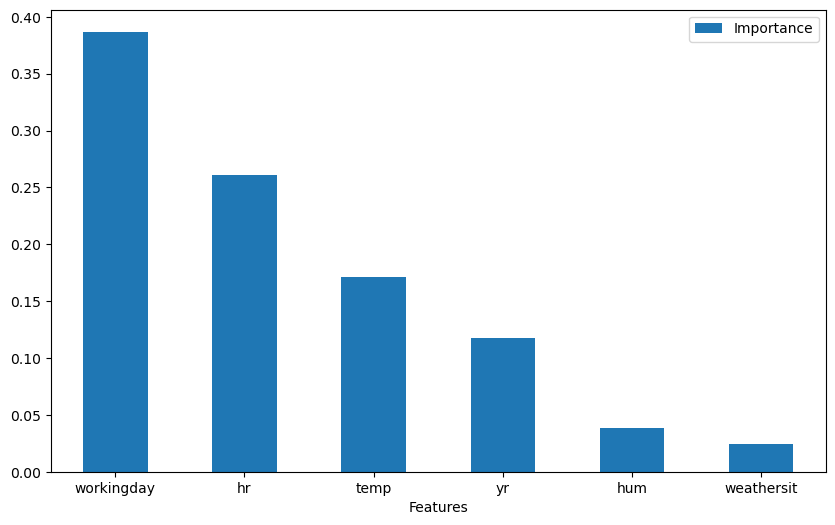

In [162]:
importance.plot.bar(x = 'Features',
                    y = 'Importance', 
                    rot=0, figsize=(10, 6))

In [163]:
# prediction
train_pred_c = model_xgb_c.predict(X_train_c.values)
test_pred_c = model_xgb_c.predict(X_test_c.values)

# predicted result
train_MAPE_xgb_c = mean_absolute_percentage_error(y_train_c, train_pred_c)
test_MAPE_xgb_c = mean_absolute_percentage_error(y_test_c, test_pred_c)

print('train MAPE: ', train_MAPE_xgb_c)
print('test MAPE: ', test_MAPE_xgb_c)

train MAPE:  979225589875177.2
test MAPE:  803509583412959.6


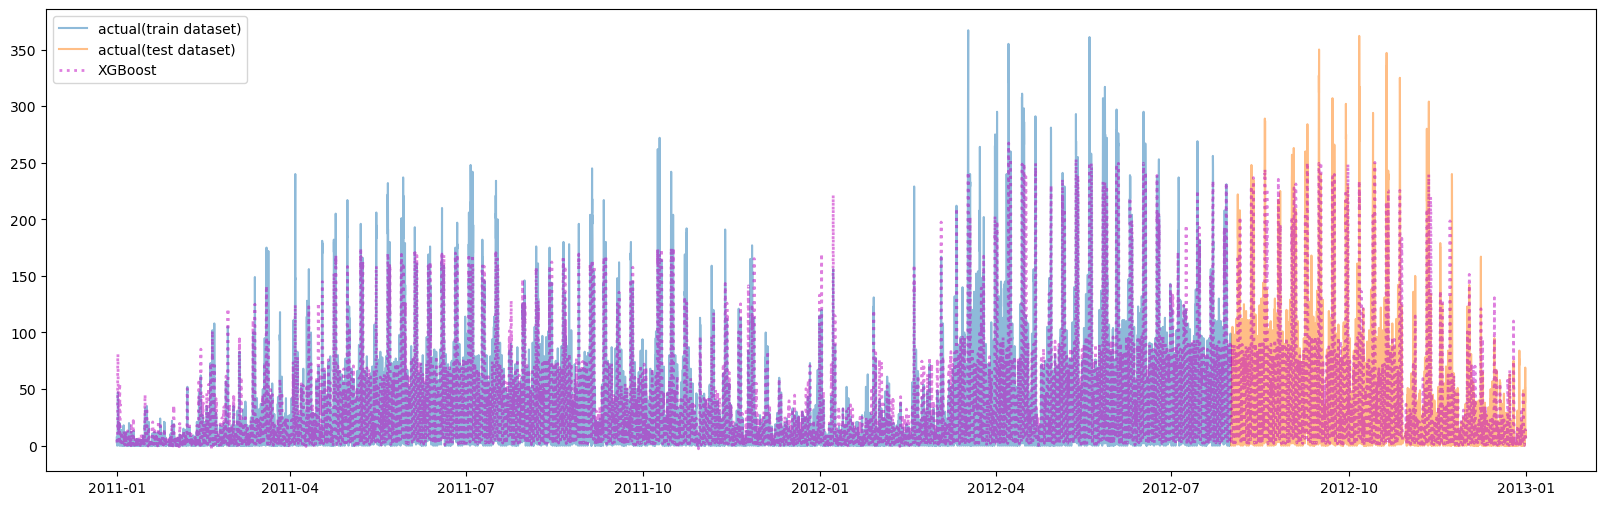

In [164]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train_c.index, y_train_c.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_test_c.index, y_test_c.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_train_c.index, train_pred_c, linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_test_c.index, test_pred_c, label="XGBoost", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [165]:
y_test_c.head()

,casual
datetime,
2012-08-01 00:00:00,3
2012-08-01 01:00:00,5
2012-08-01 02:00:00,0
2012-08-01 03:00:00,0
2012-08-01 04:00:00,1


In [166]:
xgb_result_c = pd.DataFrame({'actual' : y_test_c.values.flatten(),
                              'pred' : test_pred_c.flatten()})
print(xgb_result_c.describe())

            actual         pred
count  3632.000000  3632.000000
mean     42.887390    41.009720
std      55.980942    51.069538
min       0.000000     0.226835
25%       5.000000     6.352319
50%      22.000000    20.963053
75%      61.000000    60.463422
max     362.000000   250.277054


1.2) Predict 'registered'

In [167]:
# reduce the feature to the selected ones.
X_train_r = X_train_r[['temp', 'hum', 'season', 'yr', 'hr']]
X_test_r = X_test_r[['temp', 'hum', 'season', 'yr', 'hr']]

In [168]:
y_train_r = y_train_r.set_index('datetime')
y_test_r = y_test_r.set_index('datetime')

In [169]:
model_xgb_r = xgb.XGBRegressor()

def objective(trial):
    
    #hyperparameter searching
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    model_xgb_r.set_params(**params)
    #CV config
    score = model_selection.cross_val_score(model_xgb_r,
                                            X_train_r,
                                            y_train_r,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    val = - score.mean()
    return val

In [170]:
# Searching for the optimal hyperparameter
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(f"The best parameters are : \n {study.best_params}")

[I 2024-03-24 20:13:22,420] A new study created in memory with name: no-name-cca4e457-44f8-43fb-a52f-12e2e751cce4
C:\Users\Ryo\AppData\Local\Temp\ipykernel_22080\612873714.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-03-24 20:13:28,324] Trial 0 finished with value: 19137.26605372609 and parameters: {'max_depth': 9, 'n_estimators': 513, 'learning_rate': 2.910179115417038e-08}. Best is trial 0 with value: 19137.26605372609.
[I 2024-03-24 20:13:33,934] Trial 1 finished with value: 5890.308097772513 and parameters: {'max_depth': 8, 'n_estimators': 699, 'learning_rate': 0.02123612640519873}. Best is trial 1 with value: 5890.308097772513.
[I 2024-03-24 20:13:36,247] Trial 2 finished with value: 5259.31025035377 and parameters: {'max_depth': 4, 'n_estimators': 689, 'learning_rate': 0.02223524919406972}. Best is trial 2 wi

The best parameters are : 
 {'max_depth': 5, 'n_estimators': 648, 'learning_rate': 0.010504905438927499}


In [171]:
model_xgb_r = xgb.XGBRegressor(**study.best_params)
model_xgb_r.fit(X_train_r.values, y_train_r.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010504905438927499,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=648, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [172]:
importance = pd.DataFrame(zip(X_train_r.columns,
                              model_xgb_r.feature_importances_),
                              columns=["Features","Importance"])
importance = importance.sort_values("Importance",
                                    ascending=False)
importance

,Features,Importance
4,hr,0.507615
3,yr,0.241781
0,temp,0.133311
2,season,0.079398
1,hum,0.037895


<Axes: xlabel='Features'>

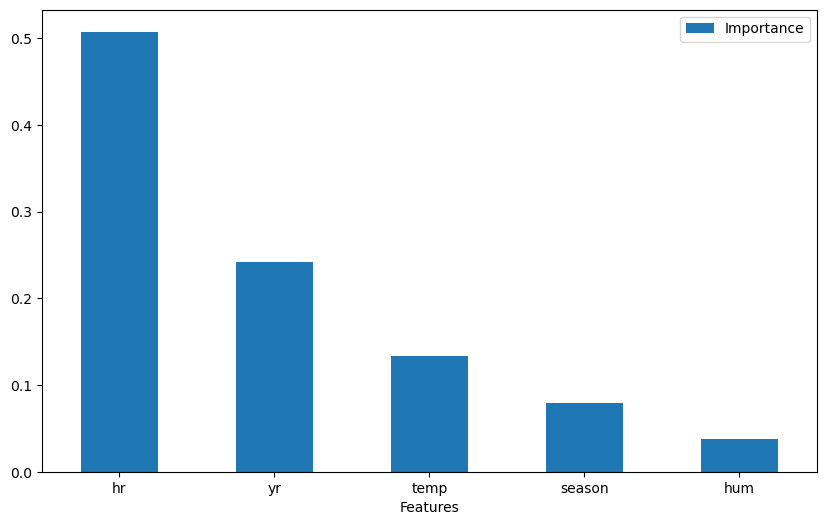

In [173]:
importance.plot.bar(x = 'Features',
                    y = 'Importance', 
                    rot=0, figsize=(10, 6))

In [174]:
# prediction
train_pred_r = model_xgb_r.predict(X_train_r.values)
test_pred_r = model_xgb_r.predict(X_test_r.values)

# predicted result
train_MAPE_xgb_r = mean_absolute_percentage_error(y_train_r, train_pred_r)
test_MAPE_xgb_r = mean_absolute_percentage_error(y_test_r, test_pred_r)

print('train MAPE: ', train_MAPE_xgb_r)
print('test MAPE: ', test_MAPE_xgb_r)

train MAPE:  55636095117796.92
test MAPE:  15775242228091.73


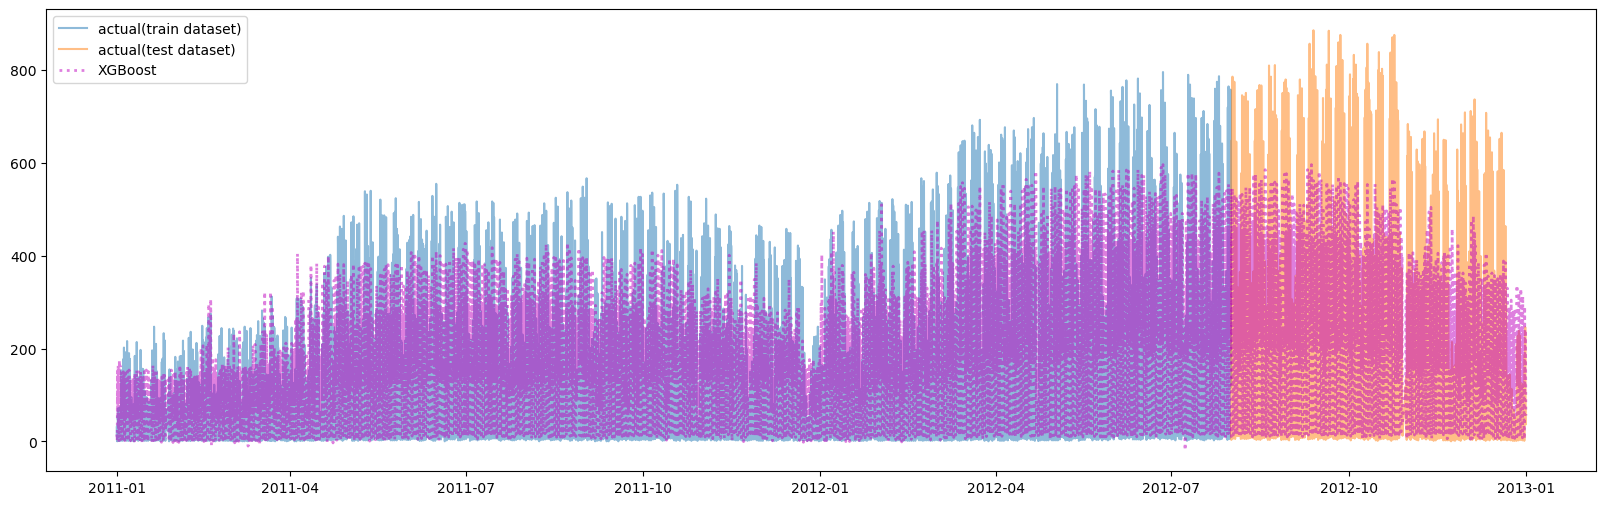

In [175]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train_r.index, y_train_r.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_test_r.index, y_test_r.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_train_r.index, train_pred_r, linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_test_r.index, test_pred_r, label="XGBoost", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [176]:
test_pred_r_flt = test_pred_r.flatten()

In [177]:
y_test_r['registered'].shape

(3632,)

In [178]:
test_pred_r.shape

(3632,)

In [179]:
xgb_result_r = pd.DataFrame({'actual' : y_test_r['registered'],
                              'pred' : test_pred_r_flt})
print(xgb_result_r.describe())

            actual         pred
count  3632.000000  3632.000000
mean    207.193557   179.927658
std     188.405218   134.443405
min       0.000000     0.857622
25%      46.750000    56.214248
50%     169.000000   179.800812
75%     303.250000   248.356678
max     886.000000   596.401550


1.3) Add 1.1. 1.2. together to derive the predicted 'cnt'

In [180]:
xgb_result_c.index = xgb_result_r.index

In [181]:
xgb_result = xgb_result_c.add(xgb_result_r)

print(xgb_result.head(5))

train_MAPE_xgb = None
test_MAPE_xgb = mean_absolute_percentage_error(xgb_result['actual'], xgb_result['pred'])
print('test MAPE: ', test_MAPE_xgb)

                     actual       pred
datetime                              
2012-08-01 00:00:00      47  70.905334
2012-08-01 01:00:00      33  43.139355
2012-08-01 02:00:00      13  25.777617
2012-08-01 03:00:00       7  13.605724
2012-08-01 04:00:00       4  12.364069
test MAPE:  0.738002417288343


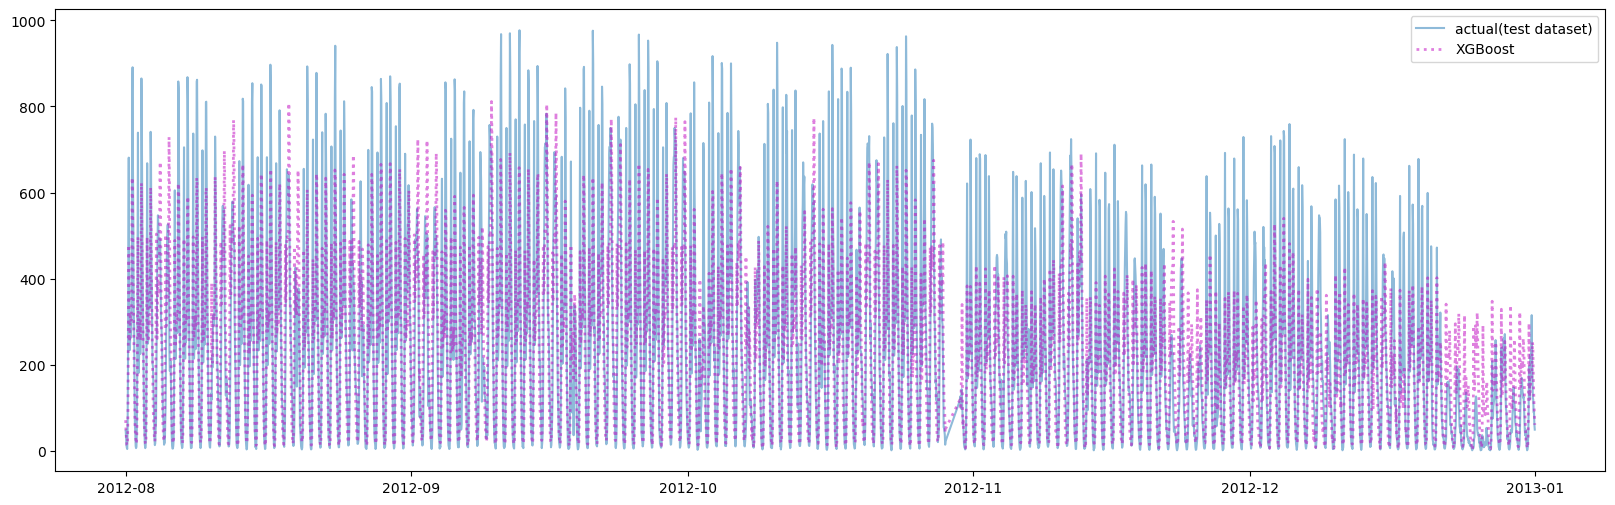

In [182]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(xgb_result.index, xgb_result['actual'].values, label="actual(test dataset)", alpha = 0.5)
ax.plot(xgb_result.index, xgb_result['pred'], label="XGBoost", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [183]:
xgb_pred_df = xgb_result['pred']

1.4) Predict 'cnt' directly

In [184]:
X_train = X_train[['temp', 'hum', 'hr', 'yr', 'season']]
X_test = X_test[['temp', 'hum', 'hr', 'yr', 'season']]

In [185]:
model_xgb = xgb.XGBRegressor()

def objective(trial):
    
    #hyperparameter searching
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }
    model_xgb.set_params(**params)
    #CV config
    score = model_selection.cross_val_score(model_xgb,
                                            X_train,
                                            y_train,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    val = - score.mean()
    return val

In [186]:
y_train = y_train.set_index('datetime')
y_test = y_test.set_index('datetime')

In [187]:
# Searching for the optimal hyperparameter
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(f"The best parameters are : \n {study.best_params}")

[I 2024-03-24 20:17:41,656] A new study created in memory with name: no-name-bfba8920-5ec6-40f5-a18d-637b07540d0c
C:\Users\Ryo\AppData\Local\Temp\ipykernel_22080\2879186294.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-03-24 20:17:44,072] Trial 0 finished with value: 24477.25448068663 and parameters: {'max_depth': 7, 'n_estimators': 282, 'learning_rate': 0.0003950368724919624}. Best is trial 0 with value: 24477.25448068663.
[I 2024-03-24 20:17:50,806] Trial 1 finished with value: 8292.39098179166 and parameters: {'max_depth': 9, 'n_estimators': 565, 'learning_rate': 0.021271735651201128}. Best is trial 1 with value: 8292.39098179166.
[I 2024-03-24 20:17:52,794] Trial 2 finished with value: 28366.214928352692 and parameters: {'max_depth': 5, 'n_estimators': 397, 'learning_rate': 2.587420870741064e-06}. Best is trial 

The best parameters are : 
 {'max_depth': 5, 'n_estimators': 307, 'learning_rate': 0.0319654287869973}


In [188]:
model_xgb = xgb.XGBRegressor(**study.best_params)
model_xgb.fit(X_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0319654287869973,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=307, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [189]:
importance = pd.DataFrame(zip(X_train.columns,
                              model_xgb.feature_importances_),
                              columns=["Features","Importance"])
importance = importance.sort_values("Importance",
                                    ascending=False)
importance

,Features,Importance
2,hr,0.463134
3,yr,0.256650
0,temp,0.168310
4,season,0.071851
1,hum,0.040056


<Axes: xlabel='Features'>

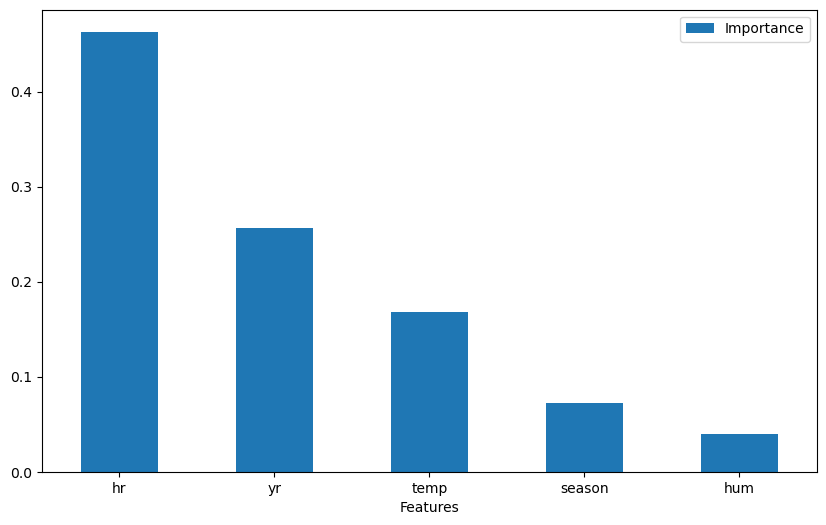

In [190]:
importance.plot.bar(x = 'Features',
                    y = 'Importance', 
                    rot=0, figsize=(10, 6))

In [191]:
# prediction
train_pred = model_xgb.predict(X_train.values)
test_pred = model_xgb.predict(X_test.values)

# predicted result
train_MAPE_xgb_direct = mean_absolute_percentage_error(y_train, train_pred)
test_MAPE_xgb_direct = mean_absolute_percentage_error(y_test, test_pred)

print('train MAPE: ', train_MAPE_xgb_direct)
print('test MAPE: ', test_MAPE_xgb_direct)

train MAPE:  0.8196911882636678
test MAPE:  0.7484089690957777


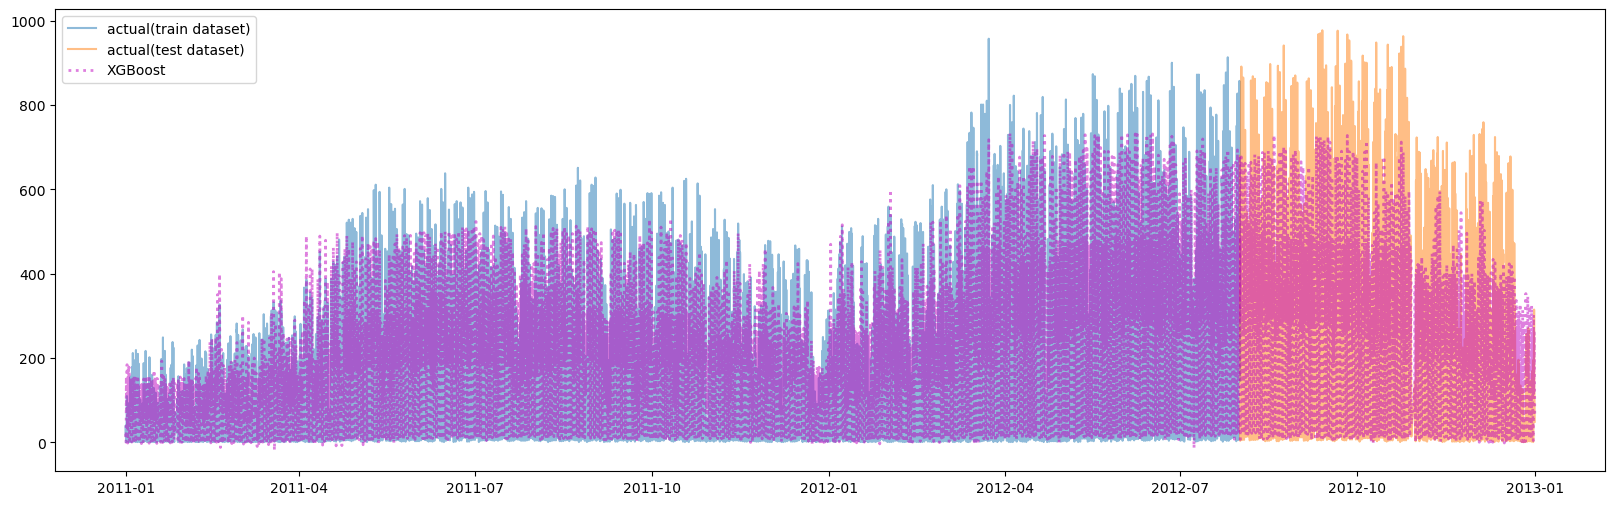

In [192]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train.index, y_train.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_test.index, y_test.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_test.index, test_pred, label="XGBoost", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [193]:
y_test

,cnt
datetime,
2012-08-01 00:00:00,47
2012-08-01 01:00:00,33
2012-08-01 02:00:00,13
2012-08-01 03:00:00,7
2012-08-01 04:00:00,4
...,...
2012-12-31 19:00:00,119
2012-12-31 20:00:00,89
2012-12-31 21:00:00,90


In [194]:
xgb_result_direct = pd.DataFrame({'actual' : y_test['cnt'],
                                  'pred' : test_pred})
print(xgb_result_direct.describe())

            actual         pred
count  3632.000000  3632.000000
mean    250.080947   222.803558
std     220.653199   167.572067
min       1.000000    -1.318521
25%      54.000000    63.413897
50%     207.000000   216.641121
75%     371.000000   333.509850
max     977.000000   728.497131


In [195]:
xgb_direct_pred_df = xgb_result_direct['pred']

Comparing the model generated in 3. and 4., it is concluded that modeling 'casual' and 'registered' separately yields slightly better result.

##### 2) LSTM : Long Short-Term Memory model

In [196]:
def build_model(hp):
    model = Sequential([
        Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), 
              activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)),
        BatchNormalization(),
        Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'),
        Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)),
        BatchNormalization(),
        Dense(units=hp.Int('units3', min_value=16, max_value=128, step=16), activation='relu'),
        Dropout(rate=hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)),
        BatchNormalization(),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    directory='hyperband',
    project_name='lstm_tuning'
)

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from hyperband\lstm_tuning\tuner0.json


In [197]:
hyperparameters = ['units1', 'dropout1', 'units2', 'dropout2', 'units3', 'dropout3', 'learning_rate']

for hp in hyperparameters:
    print(f"{hp}: {best_hps.get(hp)}")

units1: 288
dropout1: 0.1
units2: 64
dropout2: 0.1
units3: 16
dropout3: 0.0
learning_rate: 0.002907991515463253


In [198]:
model_LSTM = tuner.hypermodel.build(best_hps)
history = model_LSTM.fit(X_train, y_train, epochs=150, batch_size=24*5, validation_data=(X_test, y_test))

c:\Users\Ryo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 56210.7891 - val_loss: 102647.0859
Epoch 2/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50508.5547 - val_loss: 91159.1641
Epoch 3/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42465.3281 - val_loss: 79192.5547
Epoch 4/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33601.1289 - val_loss: 71732.5156
Epoch 5/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23347.7949 - val_loss: 55844.6758
Epoch 6/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17883.2227 - val_loss: 50971.2383
Epoch 7/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14265.9951 - val_loss: 44437.7812
Epoch 8/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11322.2393 - val_loss: 41781.1914
Epoch 9/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11102.7871 - val_loss: 36309.8242
Epoch 10/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9937.9961 - val_loss: 32227.6133
Epoch 11/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

In [199]:
'''
# Define the model architecture
model_LSTM = Sequential([
    Dense(228, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(optimizer = optimizer, 
                   loss='mean_squared_error')

# Fit the model to the training data
model_LSTM.fit(X_train, y_train, 
               epochs=150, 
               batch_size=24*5, 
               validation_data=(X_test, y_test))
'''

"\n# Define the model architecture\nmodel_LSTM = Sequential([\n    Dense(228, activation='relu', input_shape=(X_train.shape[1],)),\n    Dropout(0.2),\n    BatchNormalization(),\n    Dense(64, activation='relu'),\n    Dropout(0.2),\n    BatchNormalization(),\n    Dense(32, activation='relu'),\n    Dropout(0.2),\n    BatchNormalization(),\n    Dense(1)\n])\n\n# Compile the model\noptimizer = Adam(learning_rate=0.001)\nmodel_LSTM.compile(optimizer = optimizer, \n                   loss='mean_squared_error')\n\n# Fit the model to the training data\nmodel_LSTM.fit(X_train, y_train, \n               epochs=150, \n               batch_size=24*5, \n               validation_data=(X_test, y_test))\n"

In [200]:
# prediction
train_pred = model_LSTM.predict(X_train.values)
test_pred = model_LSTM.predict(X_test.values)


# predicted result
train_MAPE_lstm = mean_absolute_percentage_error(y_train, train_pred)
test_MAPE_lstm = mean_absolute_percentage_error(y_test, test_pred)

print('train MAPE: ', train_MAPE_lstm)
print('test MAPE: ', test_MAPE_lstm)

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
train MAPE:  1.1310630524515328
test MAPE:  0.9508386004596182


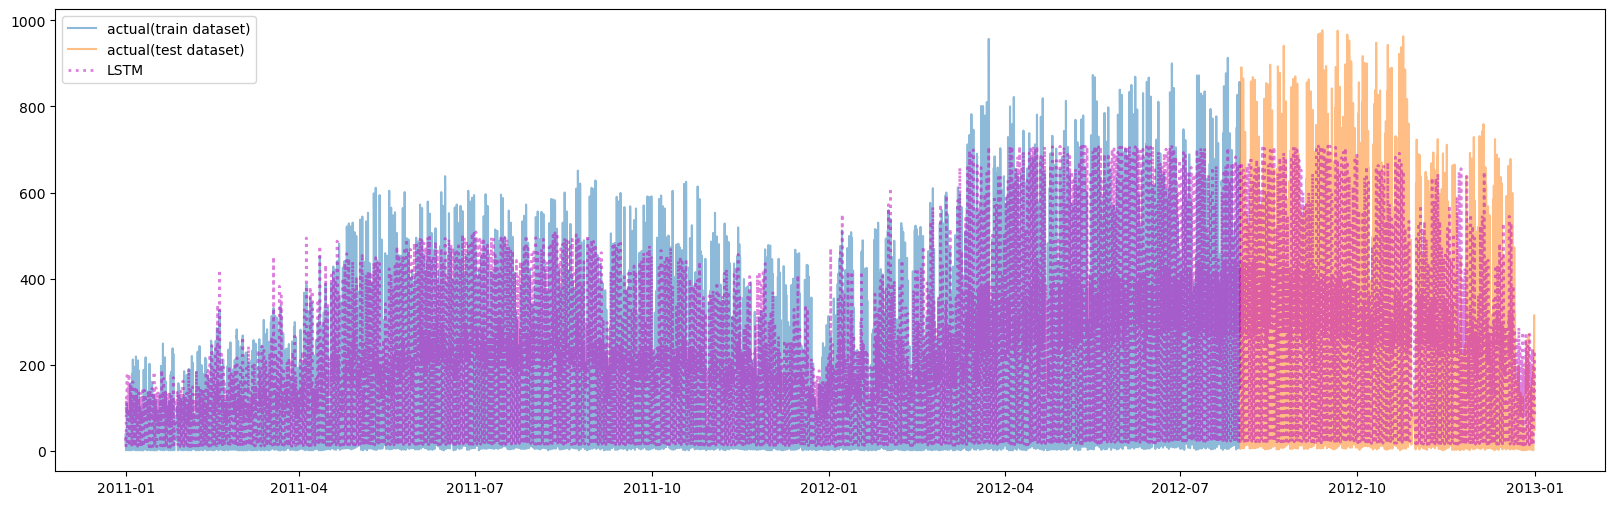

In [201]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y_train.index, y_train.values, label="actual(train dataset)", alpha = 0.5)
ax.plot(y_test.index, y_test.values, label="actual(test dataset)", alpha = 0.5)
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m", alpha = 0.5)
ax.plot(y_test.index, test_pred, label="LSTM", linestyle="dotted", lw=2, color="m", alpha = 0.5) 
plt.legend()

In [202]:
lstm_pred_df = pd.DataFrame(test_pred)
lstm_pred_df = lstm_pred_df.set_index(y_test.index)
lstm_pred_df.rename(columns={0: 'pred'}, inplace=True)
lstm_pred_df

,pred
datetime,
2012-08-01 00:00:00,89.838142
2012-08-01 01:00:00,56.748409
2012-08-01 02:00:00,42.048775
2012-08-01 03:00:00,28.564690
2012-08-01 04:00:00,21.330347
...,...
2012-12-31 19:00:00,175.914368
2012-12-31 20:00:00,146.870148
2012-12-31 21:00:00,114.323090


<hr style="border-top: 0.5px solid #b;">
<b style="font-size: 22px;">Task2</b> <h style="font-size: 18px;">  : Compare the models as well as the ensemble results using appropriate performance metrics. </h>
<hr style="border-top: 0.5px solid #b;">

In [203]:
compare = pd.DataFrame({'model' : ['XGBoost', 'XGBoost_direct', 'LSTM'],
                        'train_score(MAPE)' : [train_MAPE_xgb, train_MAPE_xgb_direct, train_MAPE_lstm],
                        'test_score(MAPE)' : [test_MAPE_xgb, test_MAPE_xgb_direct, test_MAPE_lstm]})
compare

,model,train_score(MAPE),test_score(MAPE)
0,XGBoost,NaN,0.738002
1,XGBoost_direct,0.819691,0.748409
2,LSTM,1.131063,0.950839


In [207]:
test_pred_all_model = pd.DataFrame({'actual' : y_test['cnt'],
                                    'XGBoost' : xgb_pred_df,
                                    'XGBoost_direct': xgb_direct_pred_df,
                                    'LSTM': lstm_pred_df.iloc[:,0] })

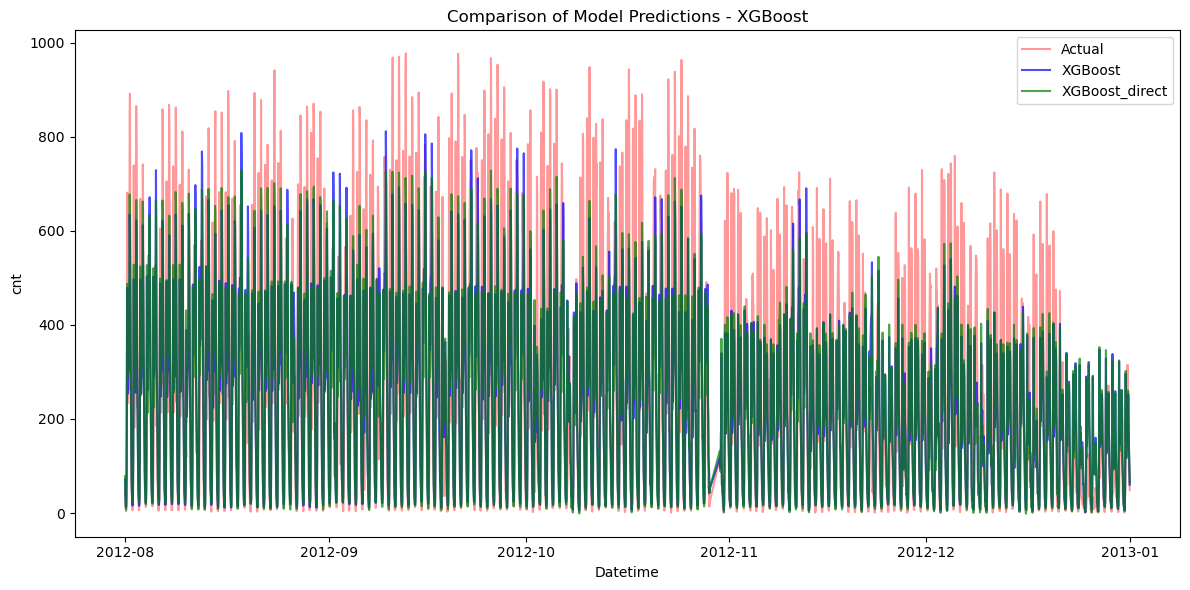

In [209]:
# Plotting the actual values and model predictions
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax.plot(test_pred_all_model.index, test_pred_all_model['actual'], label='Actual', color='red', alpha = 0.4)
ax.plot(test_pred_all_model.index, test_pred_all_model['XGBoost'], label='XGBoost', color='blue', alpha = 0.7)
ax.plot(test_pred_all_model.index, test_pred_all_model['XGBoost_direct'], label='XGBoost_direct', color='green', alpha = 0.7)

# Set the chart title and labels
ax.set_title('Comparison of Model Predictions - XGBoost')
ax.set_xlabel('Datetime')
ax.set_ylabel('cnt')

ax.legend()
plt.tight_layout()
plt.show()

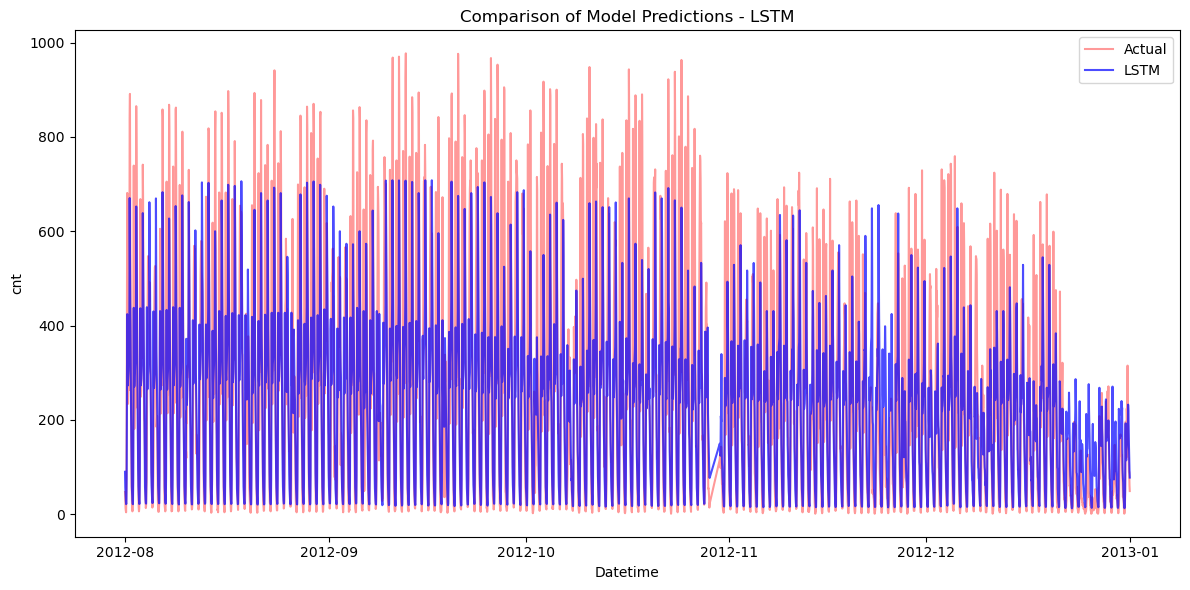

In [210]:
# Plotting the actual values and model predictions
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax.plot(test_pred_all_model.index, test_pred_all_model['actual'], label='Actual', color='red', alpha = 0.4)
ax.plot(test_pred_all_model.index, test_pred_all_model['LSTM'], label='LSTM', color='blue', alpha = 0.7)

# Set the chart title and labels
ax.set_title('Comparison of Model Predictions - LSTM')
ax.set_xlabel('Datetime')
ax.set_ylabel('cnt')

ax.legend()
plt.tight_layout()
plt.show()

The best performing model is XGBoost.

In [ ]:
2.1) Ensemble models

In [212]:
# Combine predictions using a weighted average
combined_predictions = 0.7 * test_pred_all_model['XGBoost'] + 0.3 * test_pred_all_model['XGBoost_direct'] + 0.0 * test_pred_all_model['LSTM'] 

test_MAPE_ensemble = mean_absolute_percentage_error(y_test, combined_predictions)
print('test MAPE: ', test_MAPE_ensemble)

test MAPE:  0.737434965738958


Ensembled model has the lowest loss.

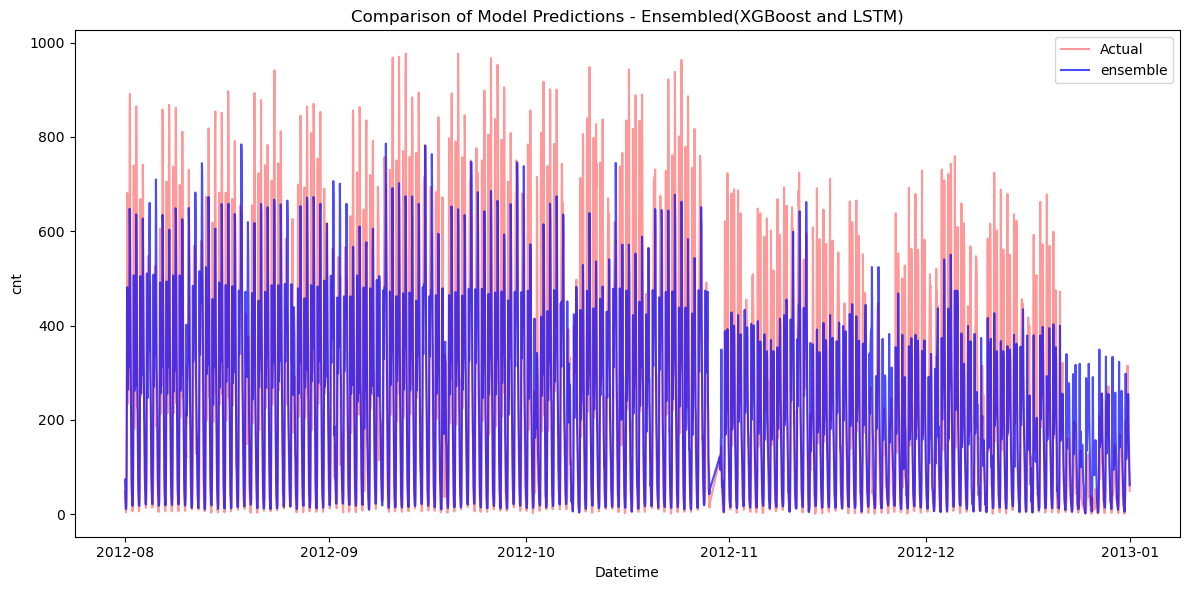

In [213]:
# Plotting the actual values and model predictions
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax.plot(test_pred_all_model.index, test_pred_all_model['actual'], label='Actual', color='red', alpha = 0.4)
ax.plot(test_pred_all_model.index, combined_predictions, label='ensemble', color='blue', alpha = 0.7)

# Set the chart title and labels
ax.set_title('Comparison of Model Predictions - Ensembled(XGBoost and LSTM)')
ax.set_xlabel('Datetime')
ax.set_ylabel('cnt')

ax.legend()
plt.tight_layout()
plt.show()